In [6]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from rich.progress import (
    Progress,
    SpinnerColumn,
    TimeElapsedColumn,
    MofNCompleteColumn,
)
import pretty_midi

# from midi_player import MIDIPlayer
# from midi_player.stylers import dark
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from scipy.spatial.distance import cosine
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import permutations
import redis

from typing import List, Dict, Tuple

## utility functions


In [30]:
def plot_images(
    images,
    titles,
    shape=None,
    main_title=None,
    set_axis: str = "off",
    bpm: int = 80,
    beats: int = 8,
    draw_beats=True,
) -> None:
    """Plot images vertically with a vertical line at each beat.

    Args:
        images: A list of images to plot.
        titles: Titles for each subplot.
        shape: The shape of the grid for subplots.
        main_title: The main title for all subplots.
        set_axis: Whether to display axis ('on' or 'off').
        bpm: Beats per minute of the MIDI file.
        beats: Total number of beats in the MIDI file.
    """
    # plt.style.use("dark_background")

    if shape is None:
        shape = [len(images), 1]

    # calculate spacing between beats in seconds
    beat_interval = 60.0 / bpm  # seconds per beat

    plt.figure(figsize=(12, 12))

    if main_title:
        plt.suptitle(main_title)
    for num_plot in range(len(images)):
        plt.subplot(shape[0], shape[1], num_plot + 1)
        plt.imshow(
            np.squeeze(images[num_plot]),
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )

        # draw vertical lines for beats
        if draw_beats:
            for beat in range(beats + 1):
                plt.axvline(x=beat * beat_interval * 100, color="green", linestyle=":")

        plt.title(titles[num_plot])
        plt.axis(set_axis)

    plt.tight_layout()
    plt.show()

In [8]:
def transpose_midi(midi_path: str) -> List[Dict]:
    """Transposes a MIDI file into all 12 semitones and returns a list of piano rolls.

    Args:
        midi_path (str): The path to the MIDI file.

    Returns:
        List: A list of dictionaries each containing the transposed midi and the transposition amount.
    """
    # load the MIDI file
    original_midi = pretty_midi.PrettyMIDI(midi_path)
    transpositions = []

    # transpose the MIDI from 0 to 11 semitones upwards
    for i in range(12):
        # create a new MIDI object for transposition
        transposed_midi = pretty_midi.PrettyMIDI()
        for instrument in original_midi.instruments:
            # create a new instrument object for each instrument
            transposed_instrument = pretty_midi.Instrument(program=instrument.program)
            for note in instrument.notes:
                # transpose each note by i semitones
                transposed_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch + i,
                    start=note.start,
                    end=note.end,
                )
                transposed_instrument.notes.append(transposed_note)
            transposed_midi.instruments.append(transposed_instrument)

        transpositions.append({"transposed_midi": transposed_midi, "transposition": i})

    return transpositions

In [9]:
def shift_midi(midi_path: str, n: int = 8, b: int = 1):
    """
    Creates all permutations of a MIDI file by cyclically shifting the notes.

    Args:
        midi_path (str): Path to the MIDI file.
        n (int): Total number of beats in the MIDI file.
        b (int): Number of beats to shift by in each permutation.

    Returns:
        list: A list of dictionaries, each containing a pretty_midi.PrettyMIDI object and the number of beats it was shifted by.
    """
    # load the MIDI file
    original_midi = pretty_midi.PrettyMIDI(midi_path)
    tempo = int(Path(midi_path).stem.split("-")[1])
    beats_per_second = tempo / 60.0
    shift_seconds = b / beats_per_second  # Convert beats to seconds for the shift

    # calculate the number of permutations
    num_permutations = int(n / b)

    permutations = []
    for shift_index in range(num_permutations):
        # create a new MIDI object for each permutation
        shifted_midi = pretty_midi.PrettyMIDI()
        for instrument in original_midi.instruments:
            shifted_instrument = pretty_midi.Instrument(
                program=instrument.program, is_drum=instrument.is_drum
            )
            for note in instrument.notes:
                # shift the start and end times of each note
                shifted_start = (note.start + shift_seconds * shift_index) % (
                    n / beats_per_second
                )
                shifted_end = (note.end + shift_seconds * shift_index) % (
                    n / beats_per_second
                )
                if shifted_end < shifted_start:  # handle wrapping around the cycle
                    shifted_end += n / beats_per_second
                shifted_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=shifted_start,
                    end=shifted_end,
                )
                shifted_instrument.notes.append(shifted_note)
            shifted_midi.instruments.append(shifted_instrument)

        permutations.append({"shifted_midi": shifted_midi, "shift": shift_index * b})

    return permutations

In [10]:
def transpose_and_shift_midi(
    midi_path: str, semitones: int, beats: int
) -> pretty_midi.PrettyMIDI:
    """
    Transpose and shift a MIDI file by a specified number of semitones and beats.

    Args:
        midi_path (str): The path to the MIDI file.
        semitones (int): Number of semitones to transpose the MIDI file.
        beats (int): Number of beats to shift the MIDI events.

    Returns:
        pretty_midi.PrettyMIDI: The modified MIDI file.
    """
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    tempo = int(Path(midi_path).stem.split("-")[1])
    beats_per_second = tempo / 60.0
    shift_seconds = 1 / beats_per_second
    s_t_midi = pretty_midi.PrettyMIDI()

    # shift
    for instrument in midi_data.instruments:
        new_inst = pretty_midi.Instrument(
            program=instrument.program, is_drum=instrument.is_drum
        )
        for note in instrument.notes:
            # shift the start and end times of each note
            shifted_start = (note.start + shift_seconds * beats) % (
                8 / beats_per_second
            )
            shifted_end = (note.end + shift_seconds * beats) % (8 / beats_per_second)
            if shifted_end < shifted_start:  # handle wrapping around the cycle
                shifted_end += 8 / beats_per_second
            s_t_note = pretty_midi.Note(
                velocity=note.velocity,
                pitch=note.pitch + semitones,  # transpose
                start=shifted_start,
                end=shifted_end,
            )
            new_inst.notes.append(s_t_note)
        s_t_midi.instruments.append(new_inst)

    return s_t_midi

In [11]:
def contour(
    midi: pretty_midi.PrettyMIDI, tempo: int, num_beats: int, simple=True
) -> List[Tuple]:
    beat_duration = 60.0 / tempo
    results = []

    for beat in range(num_beats):
        start_time = beat * beat_duration
        end_time = start_time + beat_duration
        notes = []

        for instrument in midi.instruments:
            for note in instrument.notes:
                note_start = note.start
                note_end = note.end
                if note_start < end_time and note_end > start_time:
                    overlap_start = max(note_start, start_time)
                    overlap_end = min(note_end, end_time)
                    overlap_duration = overlap_end - overlap_start
                    if overlap_duration > 0:
                        notes.append((note.pitch, note.velocity, overlap_duration))

        if notes:
            pitches = np.array([note[0] for note in notes])
            velocities = np.array([note[1] for note in notes])
            durations = np.array([note[2] for note in notes])
            normalized_velocities = velocities / np.max(velocities)
            normalized_durations = durations / np.max(durations)

            weighted_avg = np.sum(
                pitches * normalized_velocities * normalized_durations
            ) / np.sum(normalized_velocities * normalized_durations)
            if simple:
                results.append(weighted_avg)
            else:
                results.append(int(np.min(pitches)))
                results.append(weighted_avg)
                results.append(int(np.max(pitches)))
        else:
            results.append(0)

            if not simple:
                results.append(0)
                results.append(0)

    return results

In [12]:
def trim_piano_roll(piano_roll, min=None, max=None):
    non_zero_rows = np.where(np.any(piano_roll > 0, axis=1))[0]

    if non_zero_rows.size == 0:
        return piano_roll

    lowest_note = non_zero_rows.min() if min is None else min
    highest_note = non_zero_rows.max() if max is None else max

    trimmed_piano_roll = piano_roll[lowest_note : highest_note + 1, :]

    return trimmed_piano_roll

In [13]:
def strip_and_pad(pr, h_max):
    trimmed_pr = trim_piano_roll(pr)

    current_h = trimmed_pr.shape[0]
    total_padding = max(h_max + 2 - current_h, 0)  # Ensure non-negative padding

    top_padding = total_padding // 2
    bottom_padding = total_padding - top_padding

    padded_pr = np.pad(
        trimmed_pr,
        ((top_padding, bottom_padding), (0, 0)),
        mode="constant",  # type: ignore
        constant_values=0,
    )

    return padded_pr

In [14]:
def blur_pr(midi: pretty_midi.PrettyMIDI, do_center: bool = True, delta_max: int = 55):
    pr = midi.get_piano_roll()
    if do_center:
        pr = strip_and_pad(pr, delta_max)
    filter = np.full((3, 3), 1 / 9)
    width = 64
    height = int(pr.shape[0] / 4)
    small_img = cv2.resize(pr, (width, height), interpolation=cv2.INTER_AREA)
    blurred_img = convolve2d(small_img, filter)

    return np.asarray(blurred_img)

In [15]:
def calc_sims(
    keys,
    metric,
    mod_table,
    main_metric,
):
    for row in keys:
        for col in keys:
            if col == row:
                value = {"sim": 1.0, "mutations": {"shift": 0, "transpose": 0}}
            else:
                max_sim = -1
                best_shift = -1
                best_trans = -1

                main_metric = list(
                    map(float, r.get(f"{row}:{metric}:0-0").decode().split(","))
                )
                for s, t in mod_table:
                    comp_metric = list(
                        map(float, r.get(f"{row}:{metric}:{s}-{t}").decode().split(","))
                    )
                    similarity = np.dot(main_metric, comp_metric) / (
                        np.linalg.norm(main_metric) * np.linalg.norm(comp_metric)
                    )

                    if similarity > max_sim:
                        max_sim = similarity
                        best_shift = s
                        best_trans = t

                value = {
                    "sim": max_sim,
                    "mutations": {"shift": best_shift, "trans": best_trans},
                }

            # results.append((f"{row}:{col}", value))
            r.json.set(f"{row}:{col}", "$", value)
            # progress.update(sims_task, advance=1)
    return 1

## setup


In [16]:
dataset_path = "../data/datasets/careful"

In [17]:
properties_path = "../data/outputs/careful.json"
properties = {}
with open(properties_path, "r") as f:
    properties = json.load(f)

In [18]:
vectors = [
    {
        "name": filename,
        "metric": details["properties"]["pitch_histogram"],
    }
    for filename, details in properties.items()
]
names = [v["name"] for v in vectors]
# metrics = [v["metric"] for v in vectors]
names.sort()

In [19]:
labels = [
    "loop  ",
    "prev 1",
    "next 1",
    "prev 2",
    "next 2",
    "diff 1",
    "diff 2",
    "diff 3",
    "diff 4",
    "diff 5",
]
column_labels = [[label, f"sim-{i + 1}"] for i, label in enumerate(labels)]
column_labels = [label for sublist in column_labels for label in sublist]

table = pd.DataFrame(
    (),
    index=names,
    columns=names,  # labels,
)
table

,20231220-80-01_0000-0008.mid,20231220-80-01_0008-0016.mid,20231220-80-01_0016-0024.mid,20231220-80-01_0024-0032.mid,20231220-80-01_0032-0040.mid,20231220-80-01_0040-0048.mid,20231220-80-01_0048-0056.mid,20231220-80-01_0056-0064.mid,20231220-80-01_0064-0072.mid,20231220-80-01_0072-0080.mid,...,20240227-76-05_0872-0880.mid,20240227-76-05_0880-0888.mid,20240227-76-05_0888-0896.mid,20240227-76-05_0896-0904.mid,20240227-76-05_0904-0912.mid,20240227-76-05_0912-0920.mid,20240227-76-05_0920-0928.mid,20240227-76-05_0928-0936.mid,20240227-76-05_0936-0944.mid,20240227-76-05_0944-0952.mid
20231220-80-01_0000-0008.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231220-80-01_0008-0016.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231220-80-01_0016-0024.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231220-80-01_0024-0032.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20231220-80-01_0032-0040.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240227-76-05_0912-0920.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20240227-76-05_0920-0928.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20240227-76-05_0928-0936.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20240227-76-05_0936-0944.mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## tests


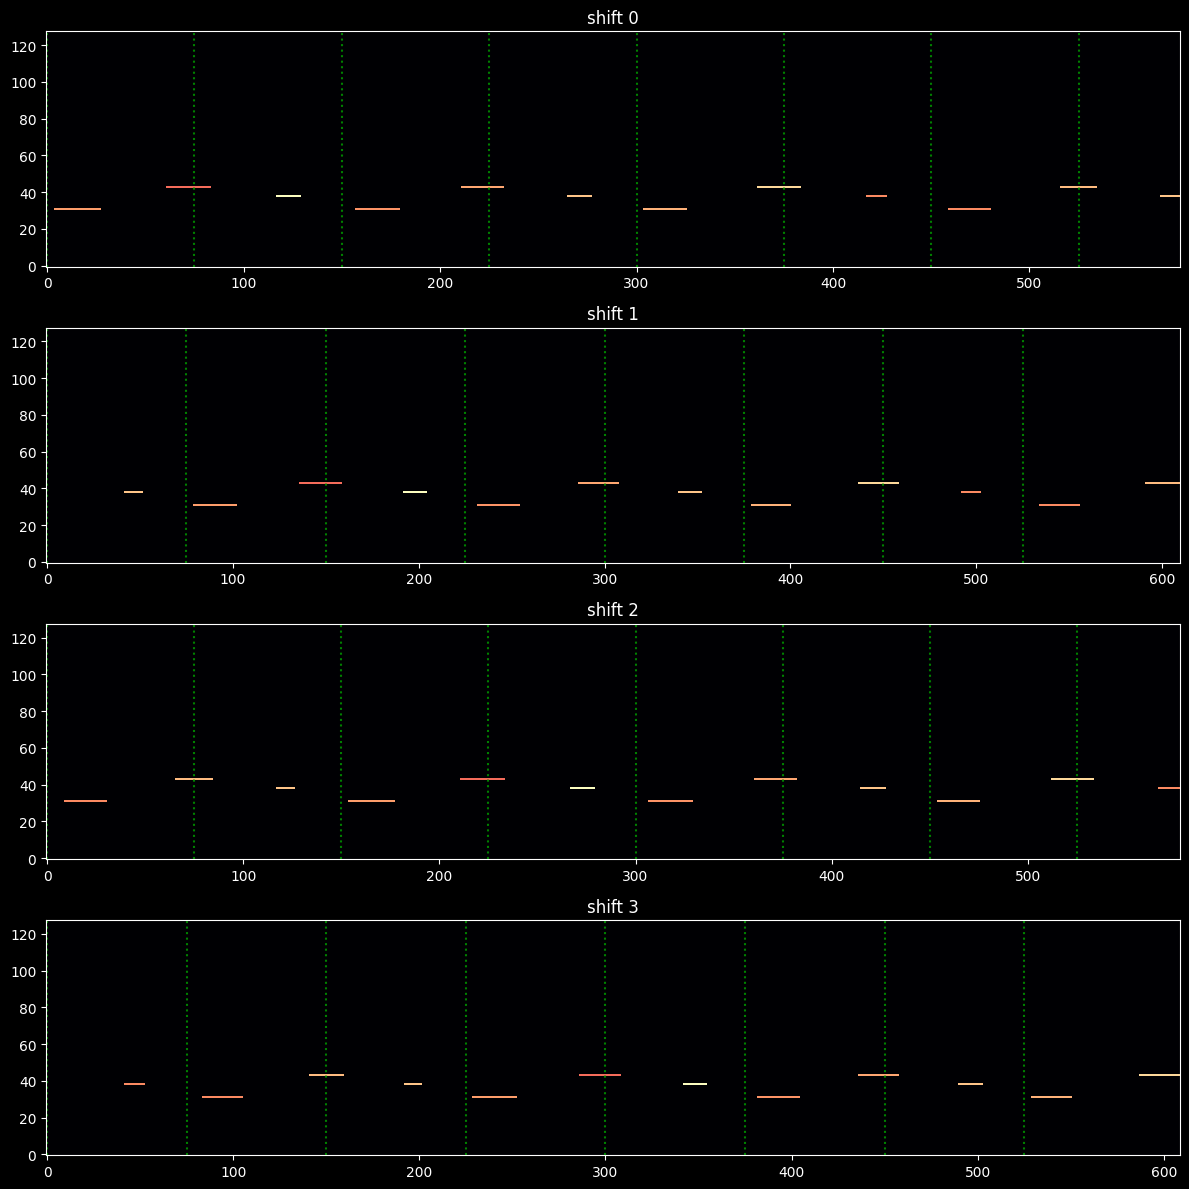

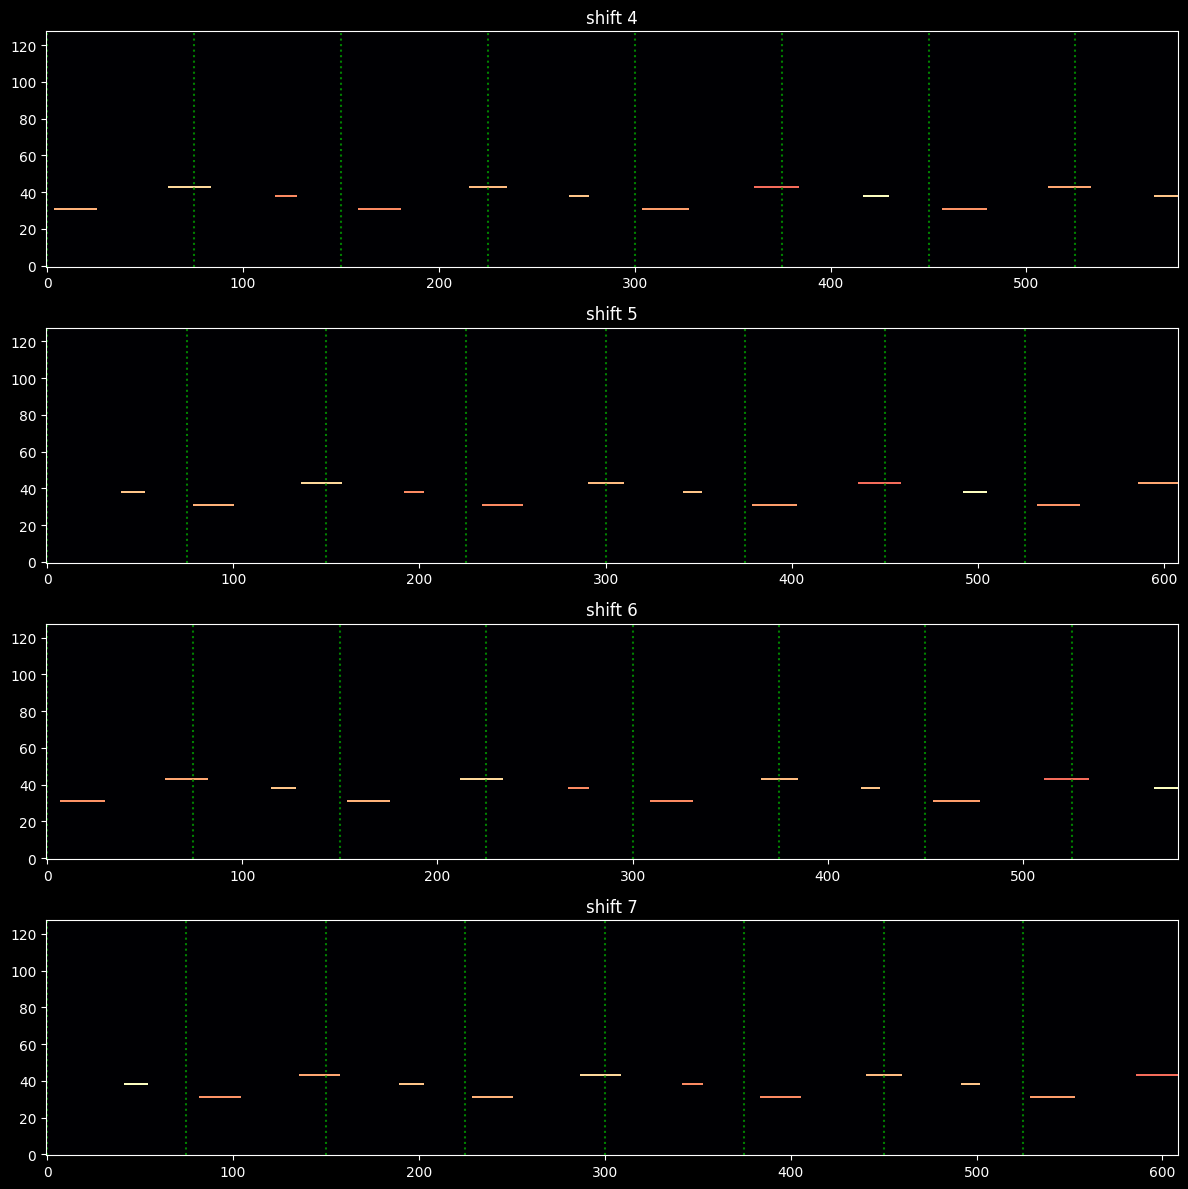

In [20]:
first_file = table.index[0]
second_file = table.index[1]
shifts = shift_midi(os.path.join(dataset_path, second_file), 8, 1)
plot_images(
    [s["shifted_midi"].get_piano_roll() for s in shifts[:4]],
    [f"shift {s['shift']}" for s in shifts[:4]],
    set_axis="on",
)
plot_images(
    [s["shifted_midi"].get_piano_roll() for s in shifts[4:]],
    [f"shift {s['shift']}" for s in shifts[4:]],
    set_axis="on",
)

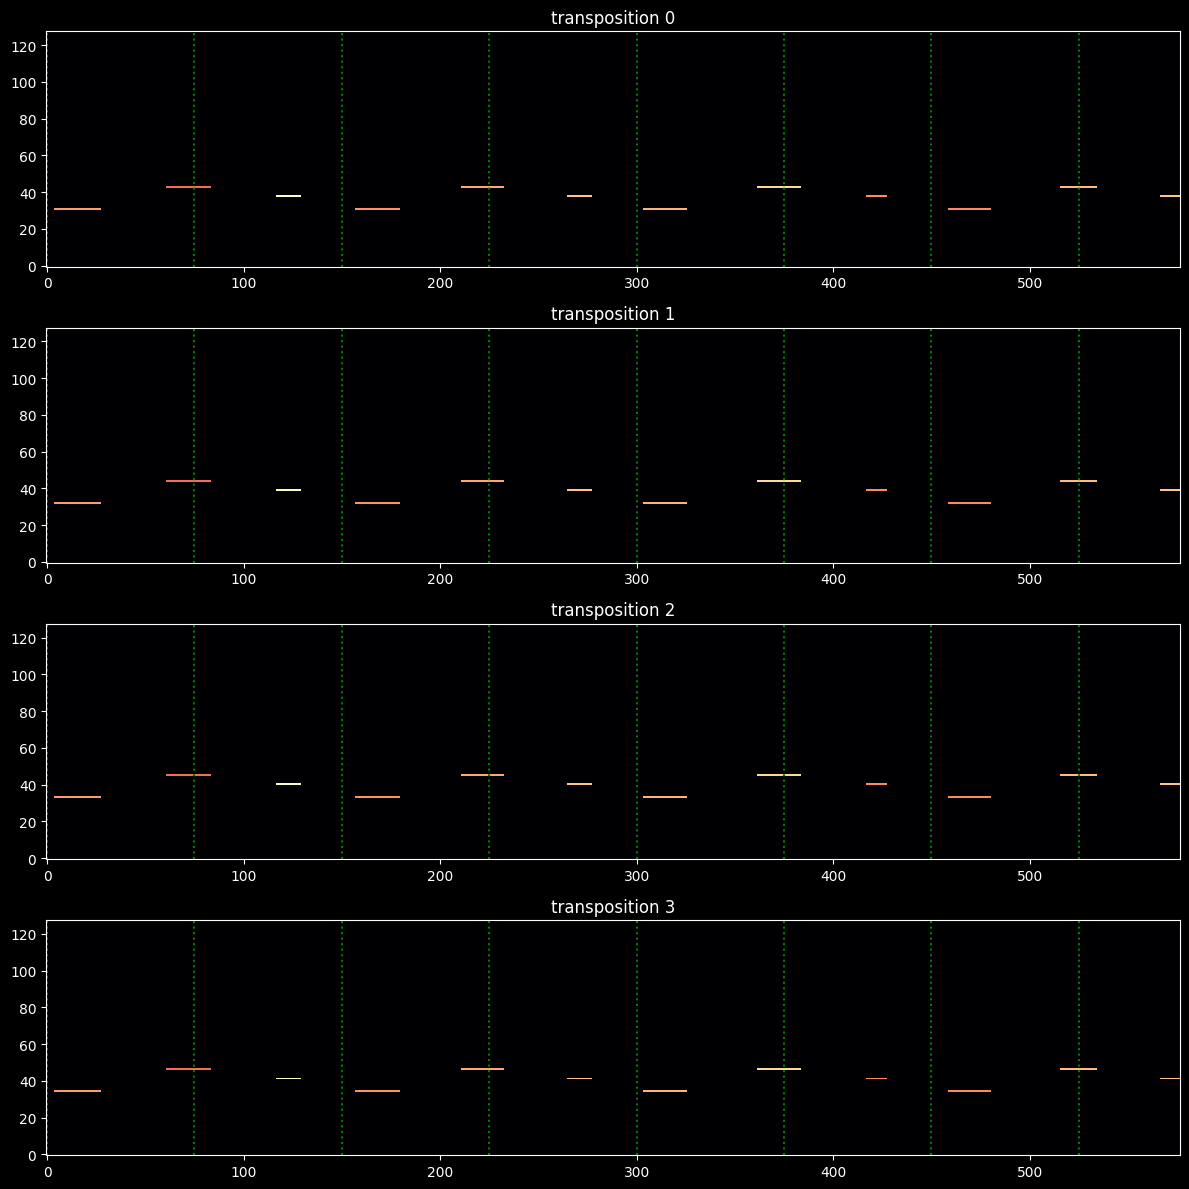

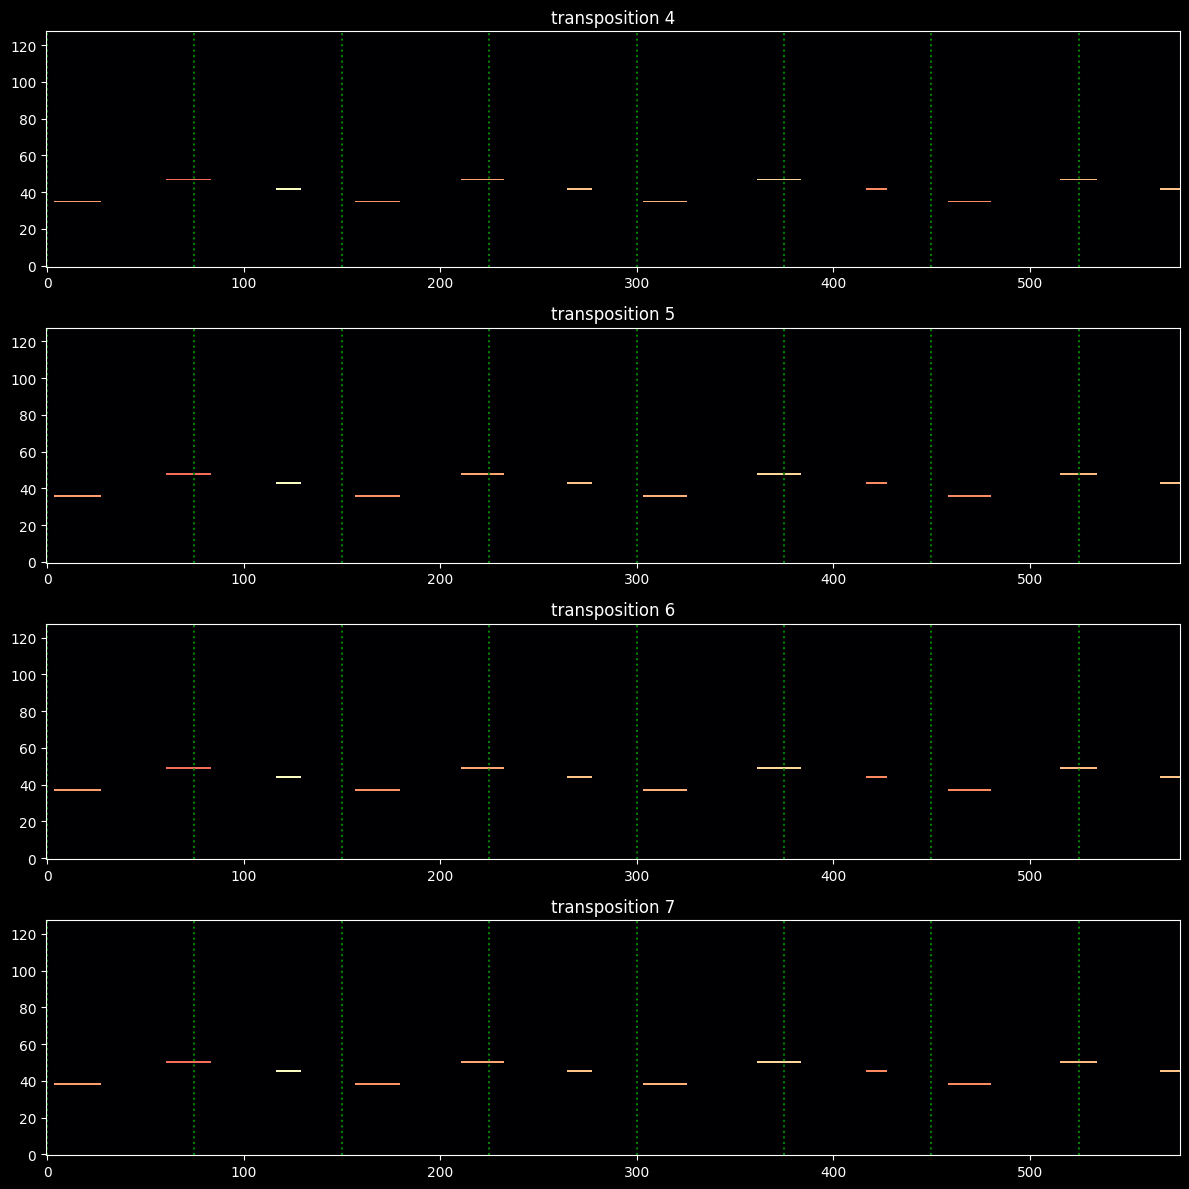

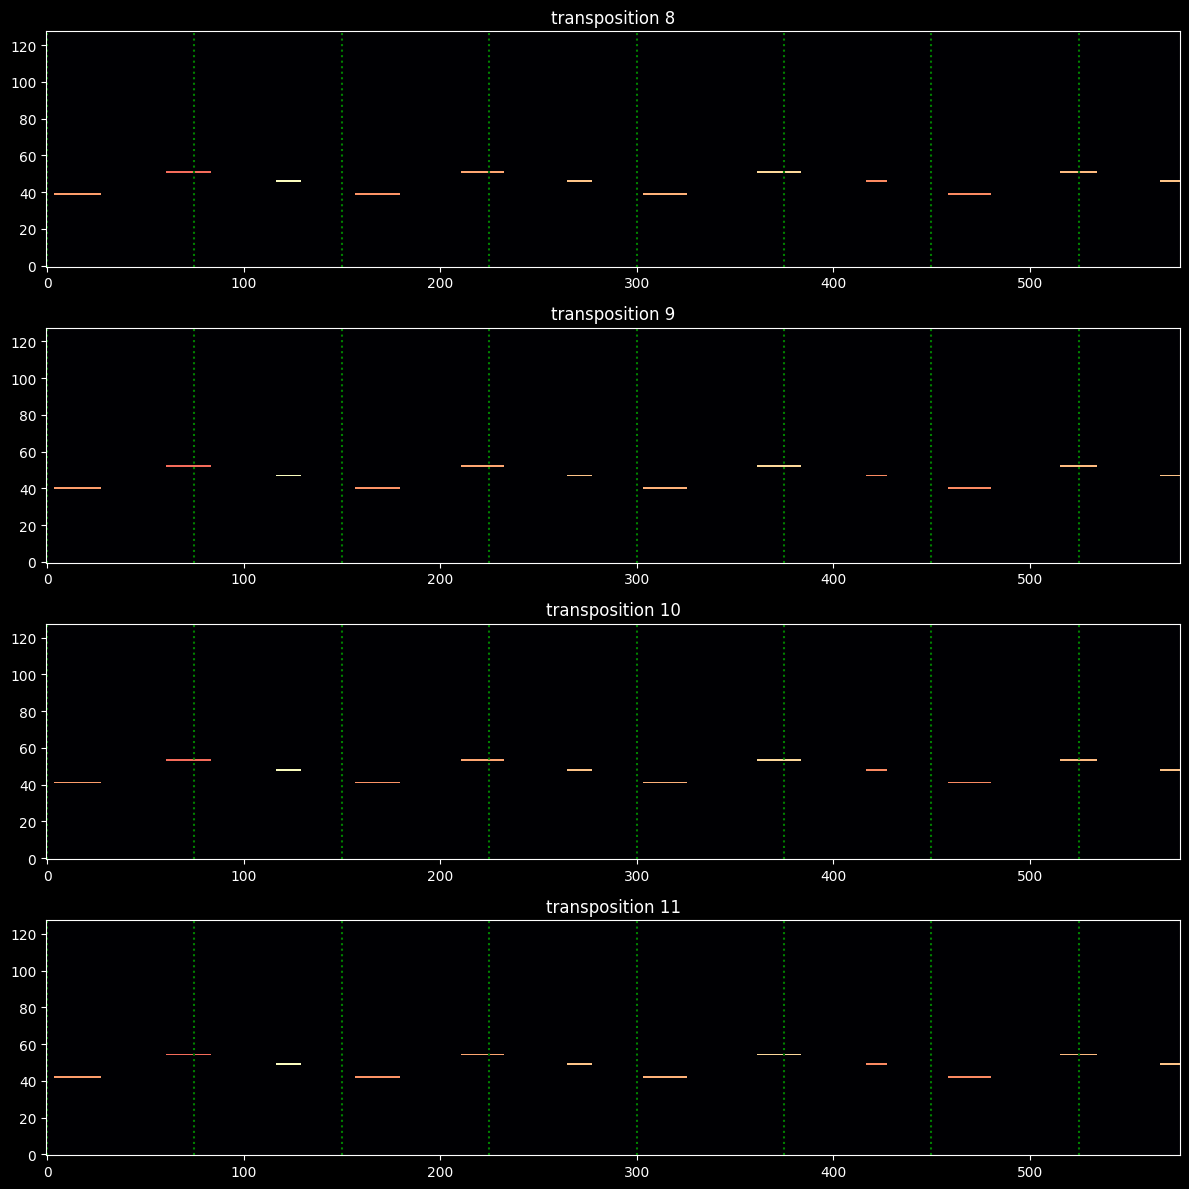

In [21]:
transposes = transpose_midi(os.path.join(dataset_path, second_file))
plot_images(
    [t["transposed_midi"].get_piano_roll() for t in transposes[:4]],
    [f"transposition {t['transposition']}" for t in transposes[:4]],
    set_axis="on",
)
plot_images(
    [s["transposed_midi"].get_piano_roll() for s in transposes[4:8]],
    [f"transposition {s['transposition']}" for s in transposes[4:8]],
    set_axis="on",
)
plot_images(
    [s["transposed_midi"].get_piano_roll() for s in transposes[8:]],
    [f"transposition {s['transposition']}" for s in transposes[8:]],
    set_axis="on",
)

In [22]:
MIDIPlayer(os.path.join(dataset_path, first_file), 400, styler=dark)

NameError: name 'MIDIPlayer' is not defined

In [ ]:
modified_path = os.path.join("tmp", "modified_midi.mid")
modified_file = transpose_and_shift_midi(os.path.join(dataset_path, first_file), 8, 2)
modified_file.write(modified_path)

MIDIPlayer(modified_path, 400, styler=dark)

## go!


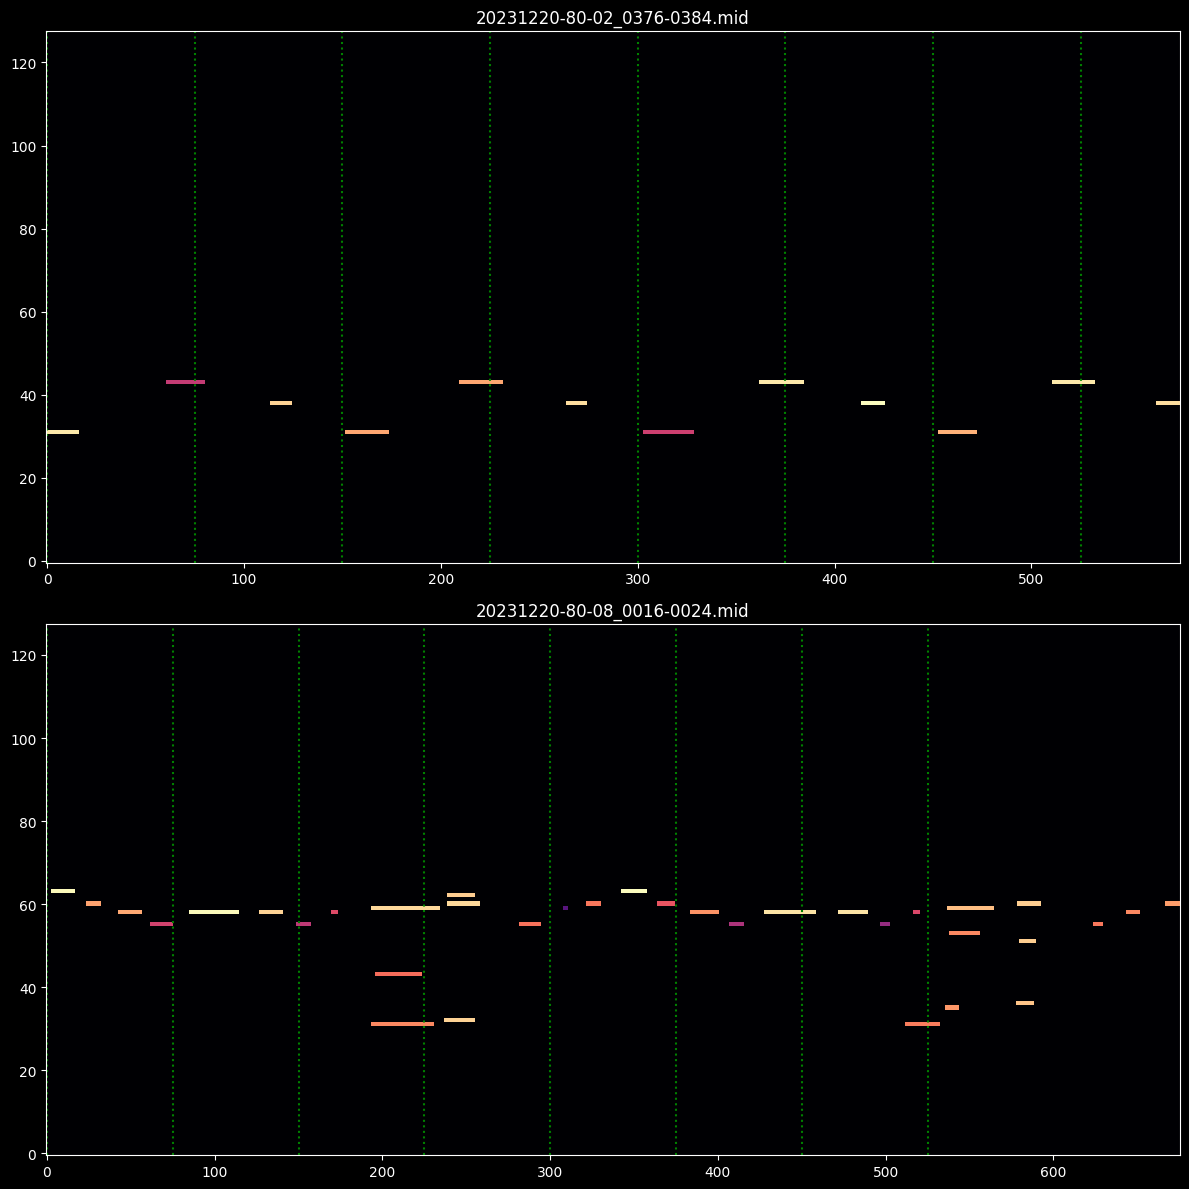

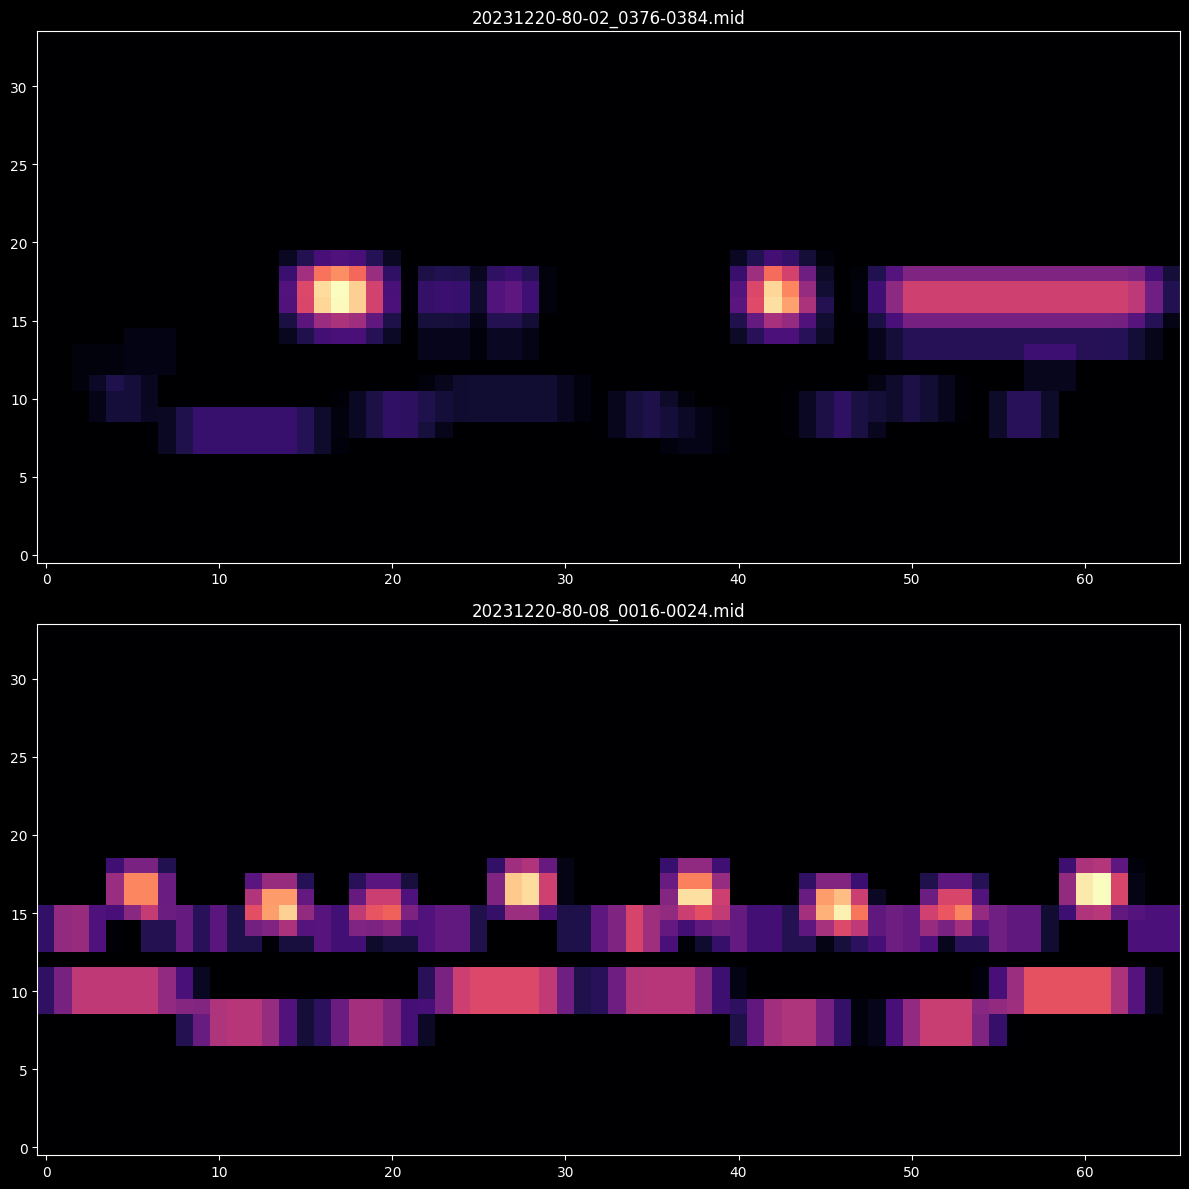

In [ ]:
plot_images(
    [
        pretty_midi.PrettyMIDI(
            os.path.join(dataset_path, "20231220-80-01_0000-0008.mid")
        ).get_piano_roll(),
        pretty_midi.PrettyMIDI(
            os.path.join(dataset_path, "20240121-70-02_1088-1096.mid")
        ).get_piano_roll(),
    ],
    [table.index[123], table.index[321]],
    set_axis="on",
)
plot_images(
    [
        blur_pr(
            pretty_midi.PrettyMIDI(os.path.join(dataset_path, table.index[123])), False
        ),
        blur_pr(
            pretty_midi.PrettyMIDI(os.path.join(dataset_path, table.index[321])), False
        ),
    ],
    [table.index[123], table.index[321]],
    set_axis="on",
    draw_beats=False,
)

### redis

calculate all mutations of each segment and store them in redis

redis has to be running with `redis-stack-server`


In [ ]:
r = redis.Redis(host="localhost", port=6379, db=0)

In [ ]:
# build list of all possible modification combinations
mod_table = []
for s in range(8):
    for t in range(12):
        mod_table.append([s, t])

progress = Progress(
    SpinnerColumn(),
    *Progress.get_default_columns(),
    TimeElapsedColumn(),
    MofNCompleteColumn(),
    refresh_per_second=1,
)
sims_task = progress.add_task("uploading pitch histograms", total=(len(names) * 96))
with progress:
    for row in table.index:
        for s, t in mod_table:
            pch = transpose_and_shift_midi(
                os.path.join(dataset_path, row), t, s
            ).get_pitch_class_histogram()
            r.set(
                f"{row}:pitch_histogram:{s}-{t}",
                ",".join(map(str, pch)),
            )
            progress.advance(sims_task)

## similarity table


In [ ]:
metric = "pitch_histogram"
num_processes = os.cpu_count()
split_keys = np.array_split(names, num_processes)  # type: ignore

In [ ]:
progress = Progress(
    SpinnerColumn(),
    *Progress.get_default_columns(),
    TimeElapsedColumn(),
    MofNCompleteColumn(),
    refresh_per_second=1,
)
sims_task = progress.add_task("calculating similarities", total=num_processes)  # type: ignore
with progress:
    with ProcessPoolExecutor() as executor:
        futures = {
            executor.submit(calc_sims, chunk, metric, mod_table, r): chunk
            for chunk in split_keys
        }

        for future in as_completed(futures):
            result = future.result()
            progress.advance(sims_task)

Output()

TypeError: cannot pickle '_thread.lock' object

In [ ]:
progress = Progress(
    SpinnerColumn(),
    *Progress.get_default_columns(),
    TimeElapsedColumn(),
    MofNCompleteColumn(),
    refresh_per_second=1,
)
sims_task = progress.add_task("calculating similarities", total=(len(names) ** 2))
with progress:
    for row in table.index:
        for col in table.columns:
            if col == row:
                value = {"sim": 1.0, "mutations": {"shift": 0, "transpose": 0}}
            else:
                max_sim = -1
                best_shift = -1
                best_trans = -1

                main_metric = list(
                    map(float, r.get(f"{row}:{metric}:0-0").decode().split(","))
                )
                for s, t in mod_table:
                    comp_metric = list(
                        map(float, r.get(f"{row}:{metric}:{s}-{t}").decode().split(","))
                    )
                    similarity = np.dot(main_metric, comp_metric) / (
                        np.linalg.norm(main_metric) * np.linalg.norm(comp_metric)
                    )

                    if similarity > max_sim:
                        max_sim = similarity
                        best_shift = s
                        best_trans = t

                value = {
                    "sim": max_sim,
                    "mutations": {"shift": best_shift, "trans": best_trans},
                }

            r.json.set(f"{row}:{col}", "$", value)
            progress.update(sims_task, advance=1)
# table.to_parquet('pitch_histogram_test.parquet')

In [ ]:
bb_table = {}

for row in [table.index[123], table.index[321]]:
    main_metric = (
        blur_pr(pretty_midi.PrettyMIDI(os.path.join(dataset_path, row)), False)
        .flatten()
        .tolist()
    )
    # pretty_midi.PrettyMIDI(
    #     os.path.join(dataset_path, row)
    # ).get_pitch_class_histogram()

    for col in [table.columns[123], table.columns[321]]:
        if col == row:
            bb_table[f"{col} to {row}"] = {
                "sim": 1,
                "mods": {"shift": 0, "trans": 0},
            }
        else:
            max_sim = -1
            best_shift = -1
            best_trans = -1
            for s, t in mod_table:
                modified_midi = transpose_and_shift_midi(
                    os.path.join(dataset_path, col), t, s
                )

                mod_metric = blur_pr(modified_midi, False).flatten().tolist()
                sim = float(1 - cosine(main_metric, mod_metric))

                # print(f"sim {sim:.04f} for s {s} and t {t}")

                if sim > max_sim:
                    max_sim = sim
                    best_shift = s
                    best_trans = t

            bb_table[f"{col} to {row}"] = {
                "sim": max_sim,
                "mods": {"shift": best_shift, "trans": best_trans},
            }
print(list(permutations([table.index[123], table.index[321]], 2)))
bb_table

In [ ]:
# build list of all possible modification combinations
mod_table = []
for s in range(8):
    for t in range(12):
        mod_table.append([s, t])

progress = Progress(
    SpinnerColumn(),
    *Progress.get_default_columns(),
    TimeElapsedColumn(),
    MofNCompleteColumn(),
    refresh_per_second=1,
)
sims_task = progress.add_task("calculating sims", total=(len(names) ** 2) * 8 * 12)
with progress:
    # for name in table.rows:
    for row in table.index:
        # main_metric = pretty_midi.PrettyMIDI(
        #     os.path.join(dataset_path, name)
        # ).get_pitch_class_histogram()
        # main_metric = contour(
        #     pretty_midi.PrettyMIDI(os.path.join(dataset_path, name)),
        #     int(Path(name).stem.split("-")[1]),
        #     8,
        #     False,
        # )
        main_metric = (
            blur_pr(pretty_midi.PrettyMIDI(os.path.join(dataset_path, row)), False)
            .flatten()
            .tolist()
        )

        for col in table.columns:
            # print(f"checking similarity of {col} to {row}")

            if col == row:
                table.at[row, col] = {"sim": 1, "mods": {"shift": 0, "trans": 0}}
            else:
                max_sim = -1
                best_shift = -1
                best_trans = -1
                # find max similarity in table
                for s, t in mod_table:
                    modified_midi = transpose_and_shift_midi(
                        os.path.join(dataset_path, col), s, t
                    )

                    # mod_metric = modified_midi.get_pitch_class_histogram()
                    # mod_metric = contour(
                    #     modified_midi, int(Path(other_name).stem.split("-")[1]), 8, False
                    # )
                    mod_metric = blur_pr(modified_midi, False).flatten().tolist()
                    sim = float(1 - cosine(main_metric, mod_metric))

                    if sim > max_sim:
                        # print(
                        #     f"sim {sim:.03f} (shift {best_shift}, trans {best_trans}) beats sim {max_sim:.03f} (shift {s}, trans {t})"
                        # )
                        max_sim = sim
                        best_shift = s
                        best_trans = t

                    progress.update(sims_task, advance=1)
                table.at[row, col] = {
                    "sim": max_sim,
                    "mods": {"shift": best_shift, "trans": best_trans},
                }
                table.at[col, row] = {
                    "sim": max_sim,
                    "mods": {"shift": best_shift, "trans": best_trans},
                }

    # print(
    #     f"best similarity match ({max_sim:.03f}) found with shift {best_shift} and trans {best_trans}"
    # )

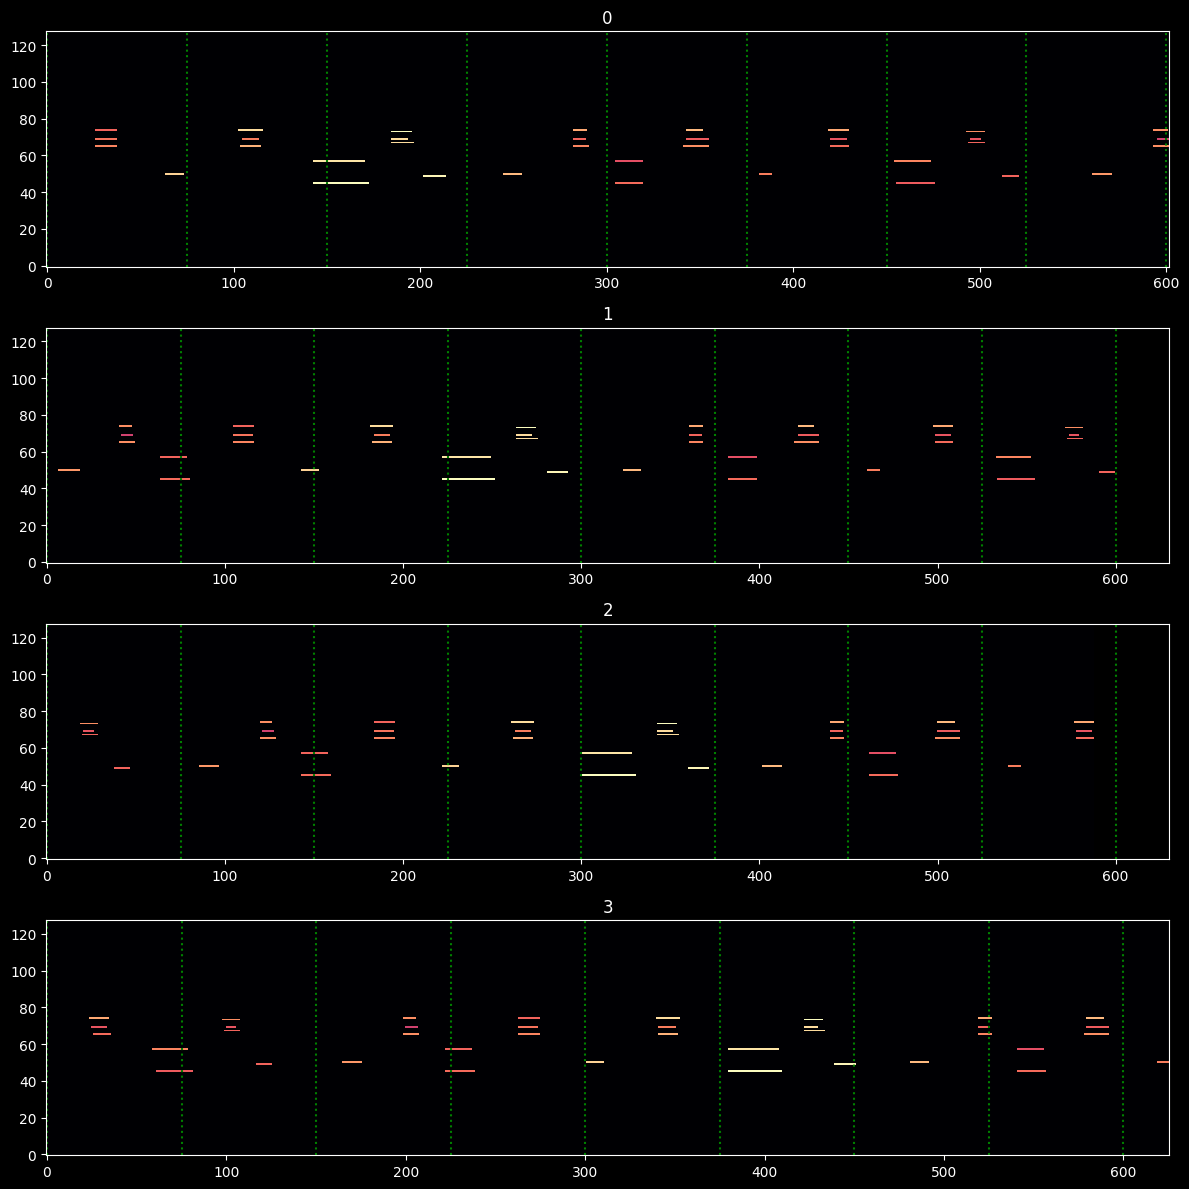

In [31]:
def transpose_and_shift_midi(
    midi_path: str, semitones: int, beats: int
) -> pretty_midi.PrettyMIDI:
    """
    Transpose and shift a MIDI file by a specified number of semitones and beats.

    Args:
        midi_path (str): The path to the MIDI file.
        semitones (int): Number of semitones to transpose the MIDI file.
        beats (int): Number of beats to shift the MIDI events.

    Returns:
        pretty_midi.PrettyMIDI: The modified MIDI file.
    """
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    tempo = int(Path(midi_path).stem.split("-")[1])
    beats_per_second = tempo / 60.0
    shift_seconds = 1 / beats_per_second
    s_t_midi = pretty_midi.PrettyMIDI()

    # shift
    for instrument in midi_data.instruments:
        new_inst = pretty_midi.Instrument(
            program=instrument.program, is_drum=instrument.is_drum
        )
        for note in instrument.notes:
            # shift the start and end times of each note
            shifted_start = (note.start + shift_seconds * beats) % (
                8 / beats_per_second
            )
            shifted_end = (note.end + shift_seconds * beats) % (8 / beats_per_second)
            if shifted_end < shifted_start:  # handle wrapping around the cycle
                shifted_end += beats / beats_per_second
            s_t_note = pretty_midi.Note(
                velocity=note.velocity,
                pitch=note.pitch + semitones,  # transpose
                start=shifted_start,
                end=shifted_end,
            )
            new_inst.notes.append(s_t_note)
        s_t_midi.instruments.append(new_inst)

    return s_t_midi


prs = []
for b in range(4):
    prs.append(
        transpose_and_shift_midi(
            os.path.join(dataset_path, table.index[-1]), 12, b
        ).get_piano_roll()
    )

plot_images(
    prs,
    [0, 1, 2, 3],
    set_axis="on",
)